In [17]:
!wget https://crisisnlp.qcri.org/data/ASONAM17_damage_images/ASONAM17_Damage_Image_Dataset.tar.gz  
!tar xvzf ASONAM17_Damage_Image_Dataset.tar.gz  

Streaming output truncated to the last 5000 lines.
ASONAM17_Damage_Image_Dataset/nepal_eq/nepal_eq_none_im_41235.jpg
ASONAM17_Damage_Image_Dataset/nepal_eq/nepal_eq_none_im_10419.jpg
ASONAM17_Damage_Image_Dataset/nepal_eq/nepal_eq_none_im_41730.jpg
ASONAM17_Damage_Image_Dataset/nepal_eq/nepal_eq_none_im_24444.jpg
ASONAM17_Damage_Image_Dataset/nepal_eq/nepal_eq_severe_im_37253.jpg
ASONAM17_Damage_Image_Dataset/nepal_eq/nepal_eq_none_im_10730.jpg
ASONAM17_Damage_Image_Dataset/nepal_eq/nepal_eq_none_im_33389.jpg
ASONAM17_Damage_Image_Dataset/nepal_eq/nepal_eq_severe_im_31342.jpg
ASONAM17_Damage_Image_Dataset/nepal_eq/nepal_eq_severe_im_7402.jpg
ASONAM17_Damage_Image_Dataset/nepal_eq/nepal_eq_severe_im_18835.jpg
ASONAM17_Damage_Image_Dataset/nepal_eq/nepal_eq_mild_im_19357.jpg
ASONAM17_Damage_Image_Dataset/nepal_eq/nepal_eq_severe_im_12162.jpg
ASONAM17_Damage_Image_Dataset/nepal_eq/nepal_eq_none_im_10493.jpg
ASONAM17_Damage_Image_Dataset/nepal_eq/nepal_eq_severe_im_6125.png
ASONAM17_Damage

In [ ]:
#!tar xvzf ASONAM17_Damage_Image_Dataset.tar.gz  

In [16]:
# REMOVE ALL THE FILE TO CLEAN UP
#!rm -rf *

In [ ]:
# !tar xvzf ASONAM17_Damage_Image_Dataset.tar.gz  

Helpful urls

https://pytorch.org/docs/stable/torchvision/models.html#classification </br>
https://pytorch.org/docs/stable/torchvision/index.html </br>
https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html </br>
https://www.learnopencv.com/ pytorch-for-beginners-image-classification-using-pre-trained-models/



# Preprocessing data

In [18]:
# <import data>
from PIL import Image
import os,shutil
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn

import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics


PyTorch Version:  1.7.0+cu101
Torchvision Version:  0.8.1+cu101


In [ ]:
#!rm -rf ASONAM17_Damage_Image_Dataset

In [19]:
# select a event
event_name = 'ecuador'
#event_name = 'nepal'
#event_name = 'ruby'
#event_name = 'matthew'


def put_data_onfile(event):
    """
    This method combines the Nepal & Ecudaor Datasets into 3 folders 
    labelled as none, mild, and extreme damage
    """
    base_path = "ASONAM17_Damage_Image_Dataset/"
    
    data_set = ['train','test','dev']
    
    category_label_dict = {}
    category_image_dict ={}

    #dataset_train
    #dataset_test
    #dataset_dev

    for data_set_category in data_set: 
        # return train or test or dev
        # ASONAM17_Damage_Image_Dataset/nepal_eq.train
        with open(base_path+event+'.'+ data_set_category) as file:
            X_data = []
            counter = 0
            for line in file:
                splits     = line.split(' ')
                image_name = splits[0]

                folder = event+'_'+ data_set_category
                if not os.path.exists(folder):
                  os.makedirs(folder)
                from_path = base_path + image_name
                first_split = (image_name[image_name.find("/")+1:]).split(' ')[0]
                to_path = folder + "/" + first_split[first_split.find("/")+1:]
                print("from " + from_path)
                print("to " + to_path)
                shutil.move(from_path,to_path)

    return category_label_dict,category_image_dict;

print("start extracting")
put_data_onfile(event_name)


start extracting
from ASONAM17_Damage_Image_Dataset/ecuador_eq/ecuador_eq_severe_im_645.jpg
to ecuador_train/ecuador_eq_severe_im_645.jpg
from ASONAM17_Damage_Image_Dataset/ecuador_eq/ecuador_eq_severe_im_1378.jpg
to ecuador_train/ecuador_eq_severe_im_1378.jpg
from ASONAM17_Damage_Image_Dataset/ecuador_eq/ecuador_eq_none_im_2609.jpg
to ecuador_train/ecuador_eq_none_im_2609.jpg
from ASONAM17_Damage_Image_Dataset/ecuador_eq/ecuador_eq_unlabelled_im_100.jpg
to ecuador_train/ecuador_eq_unlabelled_im_100.jpg
from ASONAM17_Damage_Image_Dataset/ecuador_eq/ecuador_eq_mild_im_2573.jpg
to ecuador_train/ecuador_eq_mild_im_2573.jpg
from ASONAM17_Damage_Image_Dataset/ecuador_eq/ecuador_eq_unlabelled_im_828.jpg
to ecuador_train/ecuador_eq_unlabelled_im_828.jpg
from ASONAM17_Damage_Image_Dataset/ecuador_eq/ecuador_eq_mild_im_1792.jpg
to ecuador_train/ecuador_eq_mild_im_1792.jpg
from ASONAM17_Damage_Image_Dataset/ecuador_eq/ecuador_eq_none_im_2486.jpg
to ecuador_train/ecuador_eq_none_im_2486.jpg
from 

({}, {})

Store data in inside each folders,So it can be retrieved  by dataloaders

In [20]:
!rm -rf dataset_train
!rm -rf dataset_test
!rm -rf dataset_dev

folder = event_name+'_'

if not os.path.exists('dataset_train'):
  os.makedirs('dataset_train')

if not os.path.exists('dataset_test'):
  os.makedirs('dataset_test')

if not os.path.exists('dataset_dev'):
  os.makedirs('dataset_dev')

shutil.move(folder+'train','dataset_train')
shutil.move(folder+'test','dataset_test')
shutil.move(folder+'dev','dataset_dev')


'dataset_dev/ecuador_dev'

# Load the data using dataloaders

In [21]:
# These two works for both vgg16 and alexnet
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder

    """
    # create a object definition
    #def __init__(self,**kwrgs):
    #  super(ImageFolderWithPaths, self).__init__(**kwrgs)

    
    
    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        dict_label = {'none':0,'mild':1 ,'severe':1,'unlabelled':0}
        # this is what ImageFolder normally returns 
        #print(type(self))
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        
        #print("original",original_tuple)
        #print(col)
        # the image file path
        path = self.imgs[index][0]
        file_name = path.split('/')[-1]
        intensity = file_name.split('_')[2]
        label = dict_label[intensity]
        #print("paths",path)
        #print("label",label)
        
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        image = original_tuple[0] 
        #print("len",image.shape)
        #image = preprocess(image)
        np_array = np.array(image)
        #print("tupple",original_tuple[0])
        sample = {'image':np_array, 'label': int(label)}
        return sample


# Batch size for training (change depending on how much memory you have)
batch_size = 2

# EXAMPLE USAGE:
# instantiate the dataset and dataloader
data_dir = ''+event_name+'_train'
print(data_dir)

#dataset = ImageFolderWithPaths(root=data_dir, transform=preprocess) # our custom dataset
dataset_train = ImageFolderWithPaths('dataset_train',transform= preprocess)
dataloader_train = DataLoader(dataset_train,batch_size=batch_size)

dataset_test = ImageFolderWithPaths('dataset_test',transform= preprocess)
dataloader_test= DataLoader(dataset_test,batch_size=batch_size)

dataset_dev = ImageFolderWithPaths('dataset_dev',transform= preprocess)
dataloader_dev= DataLoader(dataset_dev,batch_size=batch_size)
print("Datasets created")




ecuador_train
Datasets created


*Setting models parameter*

In [22]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
#model_name = "alexnet"
model_name = "vgg"

# Number of classes in the dataset
num_classes = 2



# Number of epochs to train for
num_epochs = 30

# learn rate
learn_rate = 0.001

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    loss_arr=[]
    acc=[]
    val_acc=[]
    val_loss_arr =[]

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for image_batch in dataloaders[phase]:
                inputs = image_batch['image'].to(device)
                labels = image_batch['label'].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        #print(outputs)
                        #print(type(outputs))
                        #print(outputs.dtype)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            if phase == 'train':
              loss_arr.append(epoch_loss)
              acc.append(epoch_acc)

            if phase =='val':
              val_acc.append(epoch_acc)
              val_loss_arr.append(epoch_loss)

              
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history,loss_arr,acc,val_acc,val_loss_arr

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

initilize the model

In [23]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

# create data loadeer for the pytorch 


Load data

In [24]:
# Send the model to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=learn_rate, momentum=0.9)

Params to learn:
	 features.0.weight
	 features.0.bias
	 features.1.weight
	 features.1.bias
	 features.4.weight
	 features.4.bias
	 features.5.weight
	 features.5.bias
	 features.8.weight
	 features.8.bias
	 features.9.weight
	 features.9.bias
	 features.11.weight
	 features.11.bias
	 features.12.weight
	 features.12.bias
	 features.15.weight
	 features.15.bias
	 features.16.weight
	 features.16.bias
	 features.18.weight
	 features.18.bias
	 features.19.weight
	 features.19.bias
	 features.22.weight
	 features.22.bias
	 features.23.weight
	 features.23.bias
	 features.25.weight
	 features.25.bias
	 features.26.weight
	 features.26.bias
	 classifier.0.weight
	 classifier.0.bias
	 classifier.3.weight
	 classifier.3.bias
	 classifier.6.weight
	 classifier.6.bias


In [25]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()
#criterion = nn.BCELoss()

dict_dataloaders = {'train':dataloader_train,'val':dataloader_dev}
# Train and evaluate
#model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

start_time = time.time()
model_ft, hist,loss_arr,acc,val_acc,val_loss_arr = train_model(model_ft, dict_dataloaders, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))
print("--- %s seconds ---" % (time.time() - start_time))


Epoch 0/29
----------
train Loss: 0.2134 Acc: 0.9415
val Loss: 3.8234 Acc: 0.6031

Epoch 1/29
----------
train Loss: 0.3192 Acc: 0.8750
val Loss: 2.0234 Acc: 0.6031

Epoch 2/29
----------
train Loss: 0.3447 Acc: 0.8363
val Loss: 2.0484 Acc: 0.6031

Epoch 3/29
----------
train Loss: 0.2871 Acc: 0.8692
val Loss: 2.1264 Acc: 0.6031

Epoch 4/29
----------
train Loss: 0.1938 Acc: 0.8955
val Loss: 2.2562 Acc: 0.6031

Epoch 5/29
----------
train Loss: 0.1136 Acc: 0.9349
val Loss: 2.6085 Acc: 0.6031

Epoch 6/29
----------
train Loss: 0.0469 Acc: 0.9846
val Loss: 3.5409 Acc: 0.6031

Epoch 7/29
----------
train Loss: 0.0234 Acc: 0.9934
val Loss: 3.3705 Acc: 0.6053

Epoch 8/29
----------
train Loss: 0.0183 Acc: 0.9963
val Loss: 4.1340 Acc: 0.6031

Epoch 9/29
----------
train Loss: 0.0145 Acc: 0.9971
val Loss: 4.9721 Acc: 0.6031

Epoch 10/29
----------
train Loss: 0.0315 Acc: 0.9898
val Loss: 4.2172 Acc: 0.6075

Epoch 11/29
----------
train Loss: 0.0195 Acc: 0.9949
val Loss: 4.9608 Acc: 0.6009

Ep

<function matplotlib.pyplot.show>

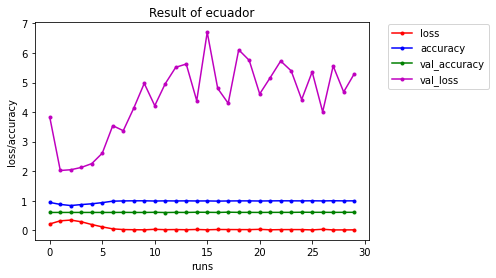

In [27]:
plt.xlabel("runs")
x_len=list(range(len(loss_arr)))
plt.title('Result of '+ event_name)
plt.ylabel("loss/accuracy")
plt.plot(x_len, loss_arr, 'r.-',label="loss")
plt.plot(x_len, acc, 'b.-', label="accuracy")
plt.plot(x_len, val_acc, 'g.-', label="val_accuracy")
plt.plot(x_len, val_loss_arr, 'm.-', label="val_loss")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.2)
plt.show

In [28]:
running_loss_test = 0
running_corrects_test = 0

for image_batch in dataloader_test:
  inputs = image_batch['image'].to(device)
  labels = image_batch['label'].to(device)


  # forward
  # track history if only in train
  phase = "test"
  with torch.set_grad_enabled(phase == 'test'):
    outputs = model_ft(inputs)
    loss = criterion(outputs, labels)
    
    _, preds = torch.max(outputs, 1)
    acc_score = accuracy_score(preds.cpu(), labels.cpu())
    confusion_matrix = metrics.confusion_matrix(preds.cpu(), labels.cpu() )
    classification_report = metrics.classification_report(preds.cpu(), labels.cpu())


  # statistics
  running_loss_test += loss.item() * inputs.size(0)
  running_corrects_test += torch.sum(preds == labels.data)

epoch_loss = running_loss_test / len(dataloader_test.dataset)
epoch_acc = running_corrects_test.double() / len(dataloader_test.dataset)

print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


test Loss: 4.6705 Acc: 0.5833


In [29]:
print(classification_report)
print(acc_score)
print(confusion_matrix)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2

1.0
[[2]]


In this disaster sepecif assigment, I vgg11 and  alexnet as the disaster specific models. 

The files as shown as bellow

files and sizes
<br>

    Euador           =  246 MB 
    Mathew hurricane =  1.29 GB 
    Nepal_eq         =  2.66 GB 
    Ruby             =  80.8 MB 


In this assignment, the models were fine tunued after loading the predifine models with their weighter. In the first portion on the project. <br>

both models performed better under learning rate 0.001 relative to 0.01. First the expeimnet started with freezing the other layers. Feature_extract bool to True will freeze the layers. <br>

To start with the assignment , I experimneted with event ruby(smaller) and nepal_eq(higher dataset), two relative dataset. 

When freeze the layers the all accuracy demonstrated low accuracy all of the performance. 

For the 30 epochs after freeze layer

<B>Vgg11</B>

    Ruby : validation loss : 2.0675 
    equador : validation loss : 9.7838
    nepal : validation loss : 5.5406 
  

unfreeze

    Ruby : validation loss : 0.9362
    equador : validation loss : 1.6584 
    nepal : validation loss : 3.7344
    


<B>ALEX net</B>

    Ruby : validation loss : 23.47
    equador : validation loss : 25.2088
    nepal : validation loss : 22.55
  

unfreeze

    Ruby : validation loss : 0.6826
    equador : validation loss : 1.45 
    nepal : validation loss :  2.75
    







Performance over test results after using feature extractions

VGG16

    Ruby test data accuracy            : 0.5321
    equador  test data accuracy        : 0.6623 
    nepal  test data accuracy          : 0.5853
  

AlexNET

    Ruby  test data accuracy           : 0.7416
    equador  test data accuracy        : 0.6576
    nepal                              : 0.6789





When all the models used weights from the pretrained models. They models performed much better. Trains were much faster in fine tuinging the last layer. Had to to decrease the batch size in event of nepal earth due to higher data volume. 

More over according to my observations, It appears that VGG11 has more potential in predicting the distaster related data.